# Scientific data technical validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide
from openslide import open_slide
from PIL import Image
from sklearn.cluster import KMeans
import cv2

## 1. Whole Slide Images (WSIs)

### Loading WSI data

In [2]:
def load_slide(filename):
    slide = open_slide(filename)
    slide_props = slide.properties  # Print this to check all metadata
    
    print("Dimensions:", slide.dimensions)
    print("X micrometer per pixel", float(slide_props['openslide.mpp-x']))
    print("Y micrometer per pixel", float(slide_props['openslide.mpp-y']))
    print("Objective power:", slide_props.get("openslide.objective-power"))
    print("Vendor:", slide_props.get("openslide.vendor"))
    
    return slide

In [5]:
slides = []
for i in range(1,4):
    print(f"TMA{i}:")
    fname = f"/home/borbende/multimodal_CRC_dataset/TMA{i}/WSI/24_TMA{i}_PA.mrxs"
    slides.append(load_slide(fname))

TMA1:
Dimensions: (105472, 227840)
X micrometer per pixel 0.242534722222222
Y micrometer per pixel 0.242647058823529
Objective power: 20
Vendor: mirax
TMA2:
Dimensions: (105472, 227840)
X micrometer per pixel 0.242534722222222
Y micrometer per pixel 0.242647058823529
Objective power: 20
Vendor: mirax
TMA3:
Dimensions: (105472, 227840)
X micrometer per pixel 0.242534722222222
Y micrometer per pixel 0.242647058823529
Objective power: 20
Vendor: mirax


In [4]:
(0.242*0.242 * 2200*2200) / 7744  # number of WSI pixels covered by a MIR spectrum

36.6025

In [7]:
2200/88   # microns in one pixel for MIR

25.0

In [6]:
slides

[OpenSlide('/home/borbende/multimodal_CRC_dataset/TMA1/WSI/24_TMA1_PA.mrxs'),
 OpenSlide('/home/borbende/multimodal_CRC_dataset/TMA2/WSI/24_TMA2_PA.mrxs'),
 OpenSlide('/home/borbende/multimodal_CRC_dataset/TMA3/WSI/24_TMA3_PA.mrxs')]

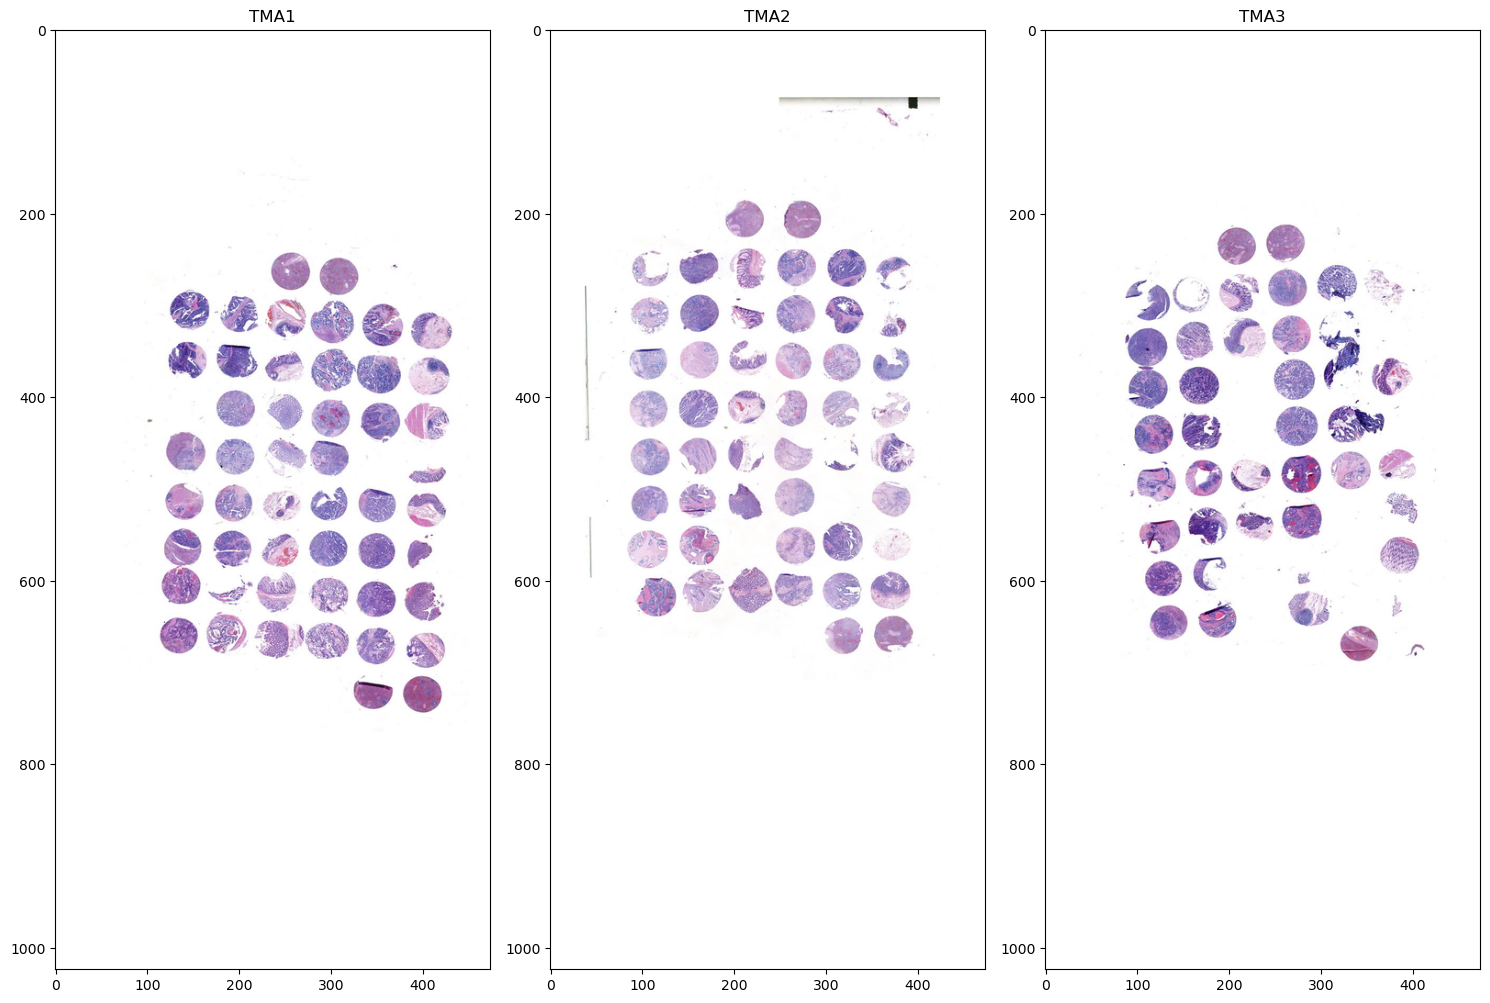

In [7]:
thumbnails = []

plt.figure(figsize = (15, 10))
for i in range(len(slides)):
    plt.subplot(1,len(slides), i + 1)
    thumbnail = slides[i].get_thumbnail((1024, 1024))  # Downsample for quick viewing
    #thumbnail.save("thumbnail.png")
    plt.imshow(thumbnail)
    plt.title(f"TMA{i+1}")
    thumbnails.append(thumbnail)

plt.tight_layout()
plt.show()

### Tissue coverage, overall blurriness, overall color distribution

In [8]:
def tissue_percentage(image: Image.Image, threshold: int = 230) -> float:
    gray = np.array(image.convert("L"))
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    tissue_area = np.sum(binary > 0)
    total_area = binary.size
    return tissue_area / total_area * 100

def is_blurry(image: Image.Image, threshold: float = 100.0) -> bool:
    gray = np.array(image.convert("L"))
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance < threshold

def plot_color_histogram(image: Image.Image):
    arr = np.array(image)
    for i, color in enumerate(['Red', 'Green', 'Blue']):
        plt.hist(arr[..., i].ravel(), bins=256, alpha=0.6, label=color)
    plt.legend()
    plt.title("Color histogram")
    plt.show()

In [9]:
metrics = []
for i in range(len(slides)):
    slide = slides[i]
    thumbnail = thumbnails[i]
    percent = tissue_percentage(thumbnail)
    blurry = is_blurry(thumbnail)
    qc_metrics = {
    "slide_id": f"TMA{i+1}",
    "dimensions": slide.dimensions,
    "tissue_coverage_%": percent,
    "is_blurry": blurry,
    "objective_power": slide.properties.get("openslide.objective-power"),
    "vendor": slide.properties.get("openslide.vendor")}
    metrics.append(pd.DataFrame([qc_metrics]))
    
metrics_df = pd.concat(metrics, ignore_index = True)
metrics_df

,slide_id,dimensions,tissue_coverage_%,is_blurry,objective_power,vendor
0,TMA1,"(105472, 227840)",12.688926,False,20,mirax
1,TMA2,"(105472, 227840)",11.933017,False,20,mirax
2,TMA3,"(105472, 227840)",9.790554,False,20,mirax


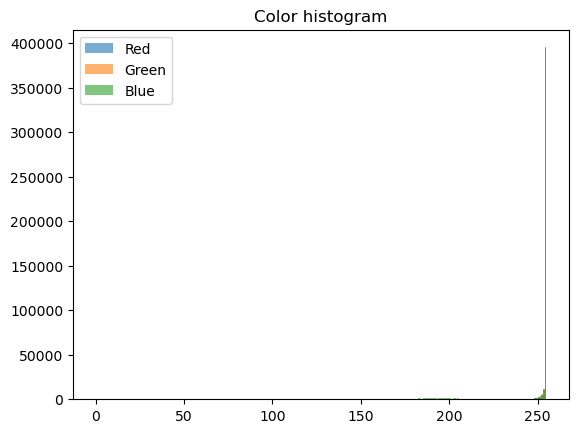

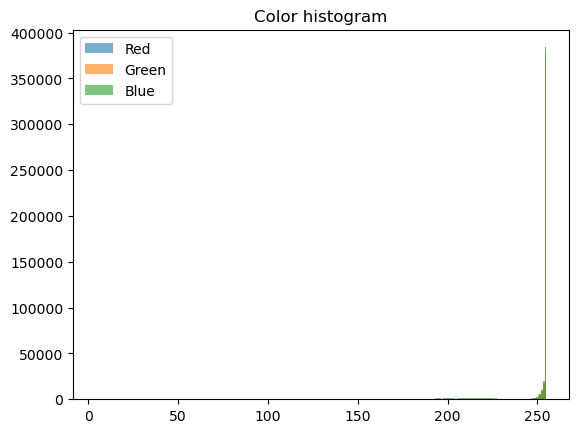

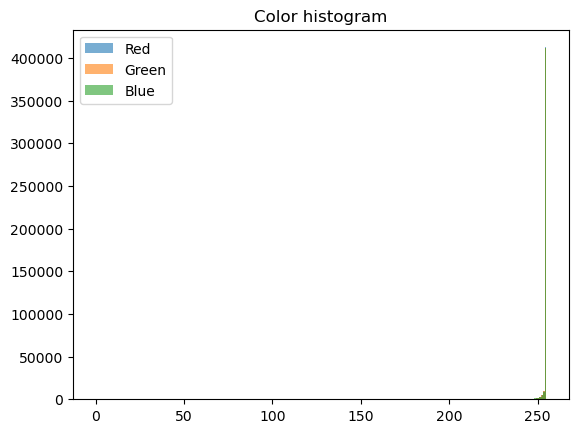

In [10]:
for i in range(len(thumbnails)):
    plot_color_histogram(thumbnails[i])

### Blurriness overlay and distribution

In [11]:
def circle_blur_detect(slide, blur_t, p1, p2):
    thumbnail_size = (2048, 2048)             # Resolution for core detection (sufficiently high resolution)
    patch_size = 256                          # Level 0 patch size
    blur_threshold = blur_t                   # Threshold to flag blurry cores (need to check how to tune)
    n_patches_per_core = 10                   # Number of random patches per core
    n_rows, n_cols = 6, 10                    # 6 rows of cores, 8+2 columns because of the four marker cores

    thumb = slide.get_thumbnail(thumbnail_size) # Map WSI and thumbnail sizes
    thumb_np = np.array(thumb)
    thumb_w, thumb_h = thumb.size
    wsi_w, wsi_h = slide.dimensions
    
    # Detecting circular tissue cores with Hough gradient method: finding possible center, then finding the best radius
    # https://docs.opencv.org/3.4/d4/d70/tutorial_hough_circle.html

    gray = cv2.cvtColor(thumb_np, cv2.COLOR_RGB2GRAY)  # Converting to grayscale
    gray_blur = cv2.medianBlur(gray, 5)                # Applying median blur to reduce noise and avoid false circle detection

    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT, # Detection method
        dp=1.5,             # Inverse ratio of resolution
        minDist=75,         # Minimum distance between detected tissue cores
        param1=p1,          # Upper threshold for edge detector
        param2=p2,          # threshold for center detection
        minRadius=10,       # These two controls circle size
        maxRadius=50
    )

    if circles is None or len(circles[0]) < 10:
        raise RuntimeError("Too few tissue cores detected to continue.")
        
    circles = np.round(circles[0, :]).astype("int")

    # Cluster core centers to assign grid positions
    x_coords = circles[:, 0].reshape(-1, 1)   # Circle center x coordinates
    y_coords = circles[:, 1].reshape(-1, 1)   # Circle center y coordinates
    x_kmeans = KMeans(n_clusters=n_cols, n_init='auto').fit(x_coords)
    y_kmeans = KMeans(n_clusters=n_rows, n_init='auto').fit(y_coords)

    # Patch sampling
    # Laplacian matrix highlights edges
    # Variance quantifies  detail (high-frequency content) amount
    # Low variance -> few edges -> likely blurry image

    patch_data = []

    for (x_thumb, y_thumb, r_thumb) in circles: # Convert thumbnail coordinates to level 0 coordinates
        x0_center = int(x_thumb / thumb_w * wsi_w)
        y0_center = int(y_thumb / thumb_h * wsi_h)
        r0 = int(r_thumb / thumb_w * wsi_w)     # Approximate radius at level 0
        # Generate patch coordinates within core circle
        rng = np.random.default_rng(seed=(x0_center + y0_center)) # deterministic randomness

        for _ in range(n_patches_per_core):
            for _ in range(10):  # Retry logic for valid patch
                dx = rng.integers(-r0 + patch_size//2, r0 - patch_size//2)                             # Randomly sample a patch
                dy = rng.integers(-r0 + patch_size//2, r0 - patch_size//2)
                if dx**2 + dy**2 <= r0**2:                                                             # Patch is inside the current circle
                    px = x0_center + dx - patch_size // 2                                              # Get pixel coordinates of the current patch
                    py = y0_center + dy - patch_size // 2
                    if 0 <= px < wsi_w - patch_size and 0 <= py < wsi_h - patch_size:                  # Ignore patches on the edge of the WSI to avoid strange patch dimensions
                        patch = slide.read_region((px, py), 0, (patch_size, patch_size)).convert("L")  # Compute blurriness on native resolution, not thumbnail
                        blur = cv2.Laplacian(np.array(patch), cv2.CV_64F).var()                        # Compute blurriness from Laplacian operator
                        patch_data.append({                                                            # Store original thumbnail circle coordinates and radius, plus blur
                            "x_thumb": round(x_thumb, 2),
                            "y_thumb": round(y_thumb, 2),
                            "r_thumb": round(r_thumb, 2),
                            "blur": blur
                        })
                        break

    patch_df = pd.DataFrame(patch_data)
    # Compute grid assignments
    patch_df["col"] = x_kmeans.predict(patch_df[["x_thumb"]].values)
    patch_df["row"] = y_kmeans.predict(patch_df[["y_thumb"]].values)

    # Aggregate per core
    core_df = patch_df.groupby(["x_thumb", "y_thumb", "r_thumb", "row", "col"]).agg(
        blur=("blur", "mean"),
        blur_std=("blur", "std"),
        n_patches=("blur", "count")
    ).reset_index()

    core_df["blurry_flag"] = core_df["blur"] < blur_threshold
    
    summary_df = pd.DataFrame({
        "Metric": [
            "Total cores detected",
            "Sharp cores (above threshold)",
            "Blurry cores (below threshold)",
            "Blurry core percentage",
            "Min blur",
            "Max blur",
            "Mean blur",
            "Median blur",
            "Standard deviation"
        ],
        "Value": [
            len(core_df),
            (~core_df["blurry_flag"]).sum(),
            core_df["blurry_flag"].sum(),
            f"{100 * core_df['blurry_flag'].mean():.1f}%",
            f"{core_df['blur'].min():.1f}",
            f"{core_df['blur'].max():.1f}",
            f"{core_df['blur'].mean():.1f}",
            f"{core_df['blur'].median():.1f}",
            f"{core_df['blur'].std():.1f}"
        ]
    })
    
    return thumb_np, core_df, summary_df

In [12]:
%%time

blur_threshold = 70
p1 = 100
p2 = 40

thumbs, core_dfs, sum_dfs = [], [], []
for i in slides:
    thumb_np, core_df, sum_df = circle_blur_detect(i, blur_threshold, p1, p2)
    thumbs.append(thumb_np)
    core_dfs.append(core_df)
    sum_dfs.append(sum_df)

CPU times: user 2.1 s, sys: 248 ms, total: 2.35 s
Wall time: 1.87 s


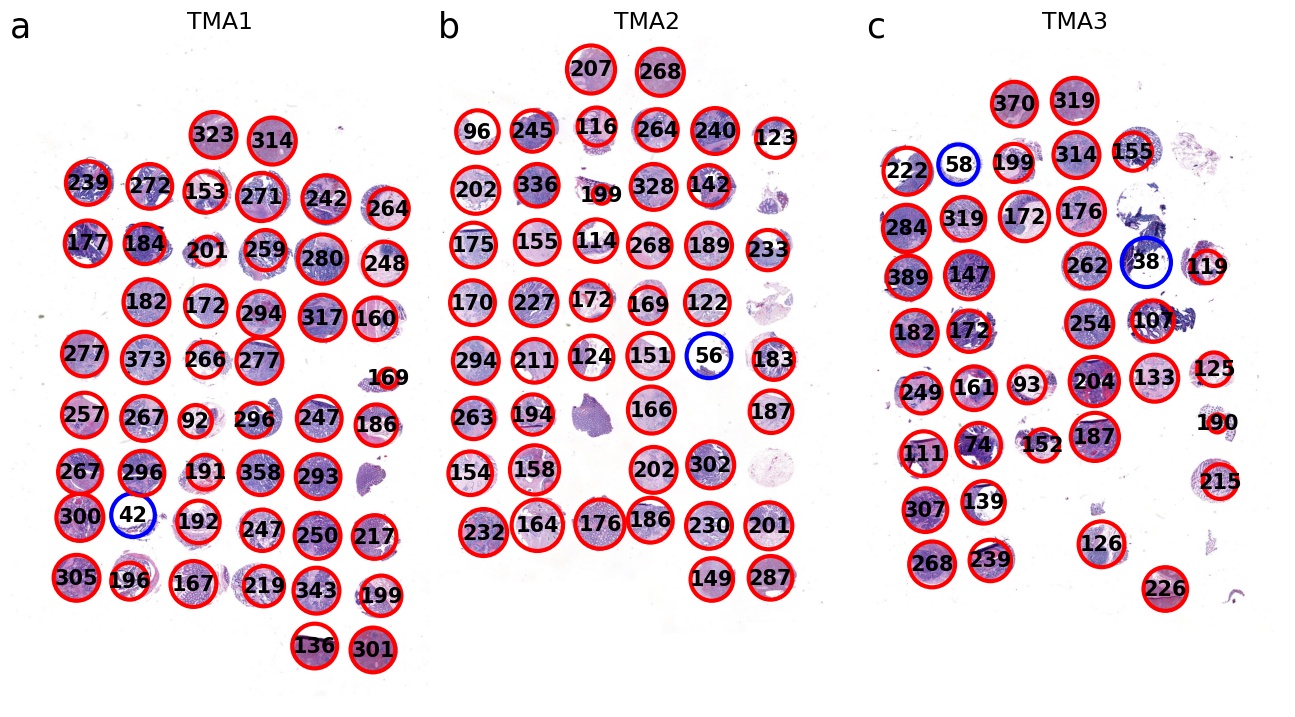

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

figlabs = ["a", "b", "c"]

for i in range(3):
    ax = axes[i]
    thumb_np = thumbs[i]
    core_df = core_dfs[i]

    ax.imshow(thumb_np)

    for _, row in core_df.iterrows():
        x, y, r = int(row["x_thumb"]), int(row["y_thumb"]), int(row["r_thumb"])
        blur = row["blur"]
        label = f"{blur:.0f}"
        color = "blue" if blur < blur_threshold else "red"

        ax.add_patch(plt.Circle((x, y), r, edgecolor=color, facecolor='none', lw=3))
        ax.text(x, y, label, color="black", fontsize=15, ha='center', va='center', weight='bold')

    ax.set_title(f"TMA{i+1}", fontsize = 17)
    ax.axis("off")
    ax.set_xlim(150, 900)
    ax.set_ylim(1550, 350)
    
    ax.text(0.0001, 0.9999, figlabs[i], transform=ax.transAxes, fontsize=25)

#fig.suptitle("TMA core sharpness overlay")
fig.subplots_adjust(
    left=0.05,   # shrink left margin
    right=0.90,  # shrink right margin
    top=0.90,    # leave room for suptitle
    bottom=0.05,
    wspace=0.02  # <--- horizontal space between plots
)

#plt.savefig("sharpness_overlay.pdf")
plt.show()

In [14]:
sum_dfs

[                           Metric  Value
 0            Total cores detected     49
 1   Sharp cores (above threshold)     48
 2  Blurry cores (below threshold)      1
 3          Blurry core percentage   2.0%
 4                        Min blur   41.6
 5                        Max blur  373.0
 6                       Mean blur  240.3
 7                     Median blur  249.8
 8              Standard deviation   67.6,
                            Metric  Value
 0            Total cores detected     46
 1   Sharp cores (above threshold)     45
 2  Blurry cores (below threshold)      1
 3          Blurry core percentage   2.2%
 4                        Min blur   56.2
 5                        Max blur  336.2
 6                       Mean blur  196.3
 7                     Median blur  187.8
 8              Standard deviation   61.6,
                            Metric  Value
 0            Total cores detected     38
 1   Sharp cores (above threshold)     36
 2  Blurry cores (below threshol